In [1]:
# Import the required libraries

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Get the data. 
# Picking the pairs to test is the secret behind a good pairs trading strategy. 
# For this example, I just use the FAANG stocks.

symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2020-01-01', 
    end='2021-01-01'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [3]:
# loop through the different combinations of pairs to test if they are co-integrated

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
# run the function on stock data.

scores, pvalues, pairs = find_cointegrated_pairs(data)

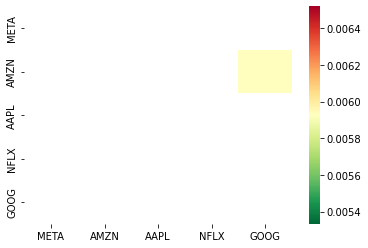

In [5]:
# plot the results on a heat map.

seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

# Save the figure.
plt.savefig("./Images/heatmap.jpg")

In [6]:
# Now that you found a pair, run a linear regression using statsmodels and model the spread as a linear combination of AAPL and AMZN.
# b is the beta coefficient from the linear regression, otherwise known as the “hedge ratio.”

S1 = data.AMZN
S2 = data.GOOG

In [7]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

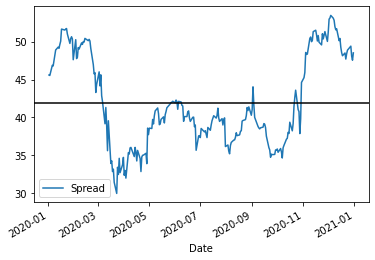

In [8]:
# visualize the spread, create a plot

spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

# Save the figure.
plt.savefig("./Images/spread.jpg")

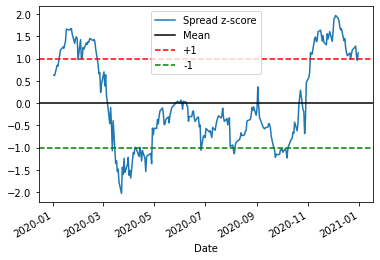

In [9]:
# Create a function to use the z-score to normalize the spread and use it as the trade signal

def zscore(series):
    return (series - series.mean()) / np.std(series)

# Visualize the zscore spread by creating a plot
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

# Save the figure.
plt.savefig("./Images/spreadZScore.jpg")

In [10]:
# estimate the equity curve of buying and selling the pair.

# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

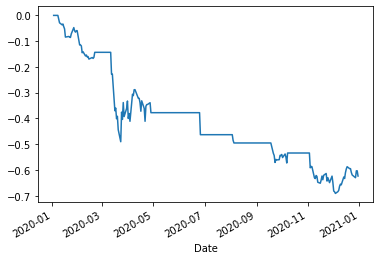

In [11]:
# plot the equity curve.

returns = trades.position.pct_change() * trades.side
returns.cumsum().plot();

# Save the figure.
plt.savefig("./Images/equityCurve.jpg")